# Question 1

In [50]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection

from scipy.fftpack import fft, fftfreq

mpl.rcParams.update({'font.size': 12})

In [51]:
# Final time of the simulation
final_time = 50.

# PDE parameter
Lx = 10.

## Part (b)

In [52]:
# Define PDE values

# Number of points in the computational grid
Nx = 256

# CFL factor
CFL = 0.05

# PDE Parameters
U0 = 0.1

In [53]:
# dx and dt
delta_x = Lx / Nx
delta_t = CFL * delta_x / U0

print("Delta t = {0:g}, Delta x = {1:g}".format(delta_t, delta_x))

# Create spatial grid
x = np.arange(delta_x / 2. - Lx/2, Lx/2, delta_x)

# Specify the number of time points to store (Nouts)
#  they will be equally spaced throughout the simulation.
Nouts = 200
output_interval = final_time / Nouts
t = np.zeros(Nouts + 1)
t[0] = 0.

# Create an array to store the solution, and write in the initial conditions
solution = np.zeros((Nouts + 1,Nx))
solution[0,:] = np.sin( 4 * np.pi * x / Lx ) + 0.25 * np.sin( 8 * np.pi * x / Lx )
u = solution[0, :]

Delta t = 0.0195312, Delta x = 0.0390625


#### Plot ICs

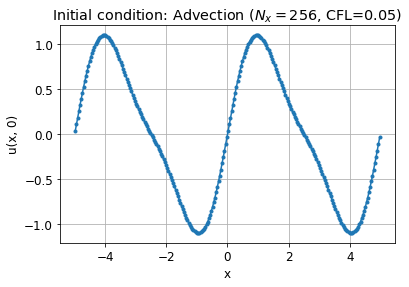

In [54]:
plt.plot( x, u, '.-' )
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title(r'Initial condition: Advection ($N_x={0}$, CFL={1})'.format(Nx, CFL))
plt.savefig('Question1/advection_ic_Nx={}.png'.format(Nx))

#### Function to Compute Derivative

In [55]:
def ddx(f, dx = delta_x):  
    dfdx = ( np.roll( f, -1 ) - np.roll(f, 1) ) / (2 * dx)   
    return dfdx

#### Compute Numerical Solution

In [56]:
curr_time = t[0]
u = solution[0,:]

next_output_time = output_interval
output_number = 0
while curr_time < final_time:
    
    # Compute the RHS of the ODE
    dudt = - U0 * ddx( u )
    
    # Update first-order record
    u = u + delta_t * dudt
    
    # Increase 'time' by Delta t
    curr_time = curr_time + delta_t
    
    # Store the new values in our array, if at the right time
    if curr_time >= next_output_time:
        output_number = output_number + 1
        next_output_time += output_interval
        
        solution[output_number,:] = u
        t[output_number] = curr_time
    
# Helps to avoid odd errors from funky step sizes
t = t[:output_number]
solution = solution[:output_number,:]

In [57]:
print( "The stored solution has {0:d} time points and {1:d} space points.".format(*solution.shape) )

The stored solution has 200 time points and 256 space points.


#### Plotting the Solution

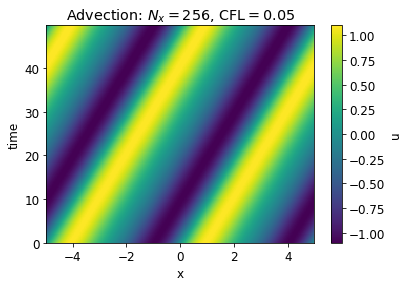

In [58]:
tmax = len(t)
cv = np.max( np.abs( solution[0,:] ) )
plt.pcolormesh( x, t[:tmax], solution[:tmax,:], vmin = -cv, vmax = cv)

cbar = plt.colorbar()
cbar.ax.set_ylabel('u')

plt.xlabel('x')
plt.ylabel('time')
plt.title('Advection: $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.savefig('Question1/advection_3d_Nx={0}_cfl={1}.png'.format(Nx, CFL))

## Part (c)

In [59]:
true_solution = np.zeros_like(solution)
# Define the Fourier modes
k2 = 4 * np.pi / Lx
k4 = 8 * np.pi / Lx

for i in range(len(t)):
    for j in range(len(x)):
        true_solution[i, j] = np.sin(k2*(x[j] - U0 * t[i])) + 0.25*np.sin(k4*(x[j] - U0 * t[i]))

#### Compute RMS

In [60]:
rms = []
for i in range(len(t)):
        rms.append(np.sqrt(np.mean((solution[i,:] - true_solution[i,:])**2)))

rms_ic = np.sqrt(np.mean(u**2))
rms_ic

0.7355241859162005

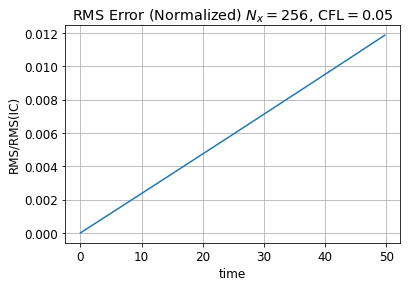

In [61]:
plt.plot(t, rms/rms_ic)
plt.xlabel('time')
plt.ylabel('RMS/RMS(IC)')
plt.title('RMS Error (Normalized) $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.grid()
plt.savefig('Question1/advection_rms_norm_Nx={0}_cfl={1}_rmsic={2:2f}.png'.format(Nx, CFL,rms_ic))

## Part (d)

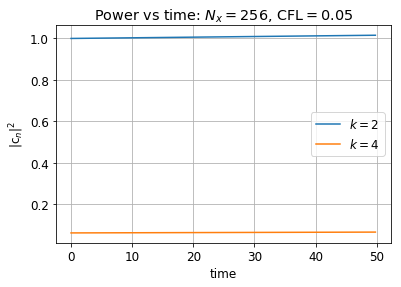

In [62]:
u_hat = fft(solution)
plt.plot(t, np.abs(2 / Nx * u_hat[:,2])**2, label = '$k=2$')
plt.plot(t, np.abs(2 / Nx * u_hat[:,4])**2, label = '$k=4$')
# plt.ylim(0,50)
plt.xlabel('time')
plt.ylabel(r'|c$_n$|$^2$')
plt.title('Power vs time: $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.grid()
plt.legend()
plt.savefig('Question1/advection_power_Nx={0}_CFL={1}.png'.format(Nx, CFL))

## Part (e)

#### Compute Energy

In [63]:
E = []
for i in range(len(t)):
    E.append(np.sum(solution[i,:]**2 * delta_x))

#### Compute True Energy from ICs

In [64]:
E_true = np.trapz(true_solution[0,:]**2, x, dx = delta_x)
E_true

5.312447076574482

#### Plot Energy vs Time

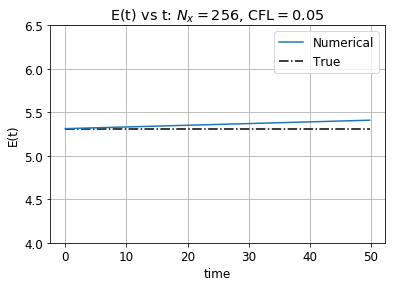

In [65]:
plt.plot(t, E, label = 'Numerical')
plt.hlines(E_true, 0, max(t), 'k', '-.', label = 'True')
plt.xlabel('time')
plt.ylabel('E(t)')
plt.title('E(t) vs t: $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.ylim(4, 6.5)
plt.grid()
plt.legend()
plt.savefig('Question1/advection_energy_with_true_Nx={0}_cfl={1}.png'.format(Nx, CFL))

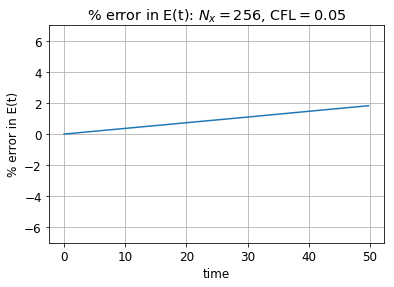

In [66]:
plt.plot(t, (E - E_true)/E_true * 100)
plt.xlabel('time')
plt.ylabel('% error in E(t)')
plt.title('% error in E(t): $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.ylim(-7, 7)
plt.grid()
plt.savefig('Question1/advection_percent_energy_Nx={0}_cfl={1}.png'.format(Nx, CFL))